In [1]:
import csv 
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis')
sys.path.append('/home/lucas/Documents/Battery')
import analog
from battery import OCVcurve, Thevenin
from scipy.interpolate import interp1d as interp1d
import matplotlib.pyplot as plt
%matplotlib notebook

### Import the equivalent circuit parameters

In [2]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R1 = float(ECparams['R1'])
C1 = float(ECparams['C1'])

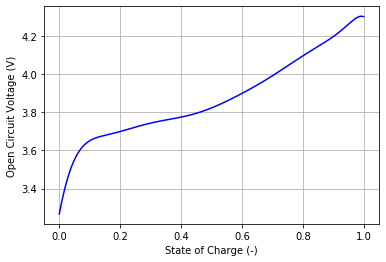

In [3]:
curve = OCVcurve('SOCvsOCV.csv')
curve.plot()

# Simulation

### Import the test file

In [4]:
folder = '/home/lucas/Documents/Log_Analysis/Logs'
log_file = analog.pathfromQGC(folder,index=39)
print(log_file)
info = analog.logextract(log_file,'battery_status')

current = info['battery_current']
time = info['time_bs']
voltage = info['battery_voltage']/4

/home/lucas/Documents/Log_Analysis/Logs/log_39_2019-8-27-14-22-40.ulg


### Tune some more simulation parameters

In [5]:
Q = 6600*3.6 # has to be in Coulombs
eta = 0.99
z0 = curve.SOCfromOCV(np.mean(voltage[0])+R0*current[0]) # taken from log to be tested
battery = Thevenin(z0,Q,curve,R0,R1,C1)

In [6]:
print(f'True measured initital voltage is {voltage[0]:.2f} V')
print(f'True initial OCV would then be {voltage[0]+R0*current[0]:.2f} V, because initial current is {current[0]:.2f} A')

True measured initital voltage is 3.72 V
True initial OCV would then be 3.72 V, because initial current is 0.00 A


### Run the simulation using the state-space model

In [7]:
%matplotlib notebook
vsim = battery.simulate(time,current,curve,plot=True)
plt.subplot(211)
plt.plot(time,voltage,label='real')
plt.legend()

<IPython.core.display.Javascript object>

/home/lucas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
plt.figure()
plt.subplot(211)
plt.plot(time,voltage,label='real')
plt.plot(time,vsim,label='simulation')
plt.legend()
plt.grid()
plt.ylabel('Cell voltage (V)')
plt.subplot(212)
plt.plot(time,current)
plt.xlabel('time (s)')
plt.ylabel('Current (A)')
plt.grid()

<IPython.core.display.Javascript object>

# Kalman Filter

In [9]:
import filterpy
from filterpy.kalman import KalmanFilter

In [12]:
dim_x = 2 # number of states
dim_z = 1 # number of outputs
kf = KalmanFilter(2,1)
battery.statespace(battery.simdt)
kf.F = battery.A 
kf.B = battery.B 

In [ ]:
xplus = np.array([0],[0])
covxplus = np.array([1,0],[0, .5])

covw = np.array([1, 0],[0, 1])
covv = 0.5

xminus = nparray()
covmxminus = np.array()
yhat = np.array()

L = 
for k in range(1,len(y)):
    # 1 : Predicition update
    xminus.append(battery.A@xplus[k-1] + battery.B@u[k-1]) # 1a : State prediction update
    covxminus.append(battery.A@covxplus[k-1]@battery.A.T + covw) # 1b : Error covariance update
    yhat.append(battery.C[k]@xminus[k] + batter.D@u[k]) # 1c : Predict system output

    # 2 : Measurement update
    L[k] = covxminus[k]@battery.C.T @ inv(battery.C@covxminus[k]@battery.C.T+covv) # 2a : Kalman gain matrix update
    xplus[k] = xminus[k] + L[k]@(y[k] - yhat[k]) # 2b : State measurement update
    covxplus[k] = covxminus[k] - L[k]@battery. C[k]@covxminus[k]